# <font color = 'indianred'>**Emotion Detection - MultiLabel** </font>

**Plan**

1. Set Environment
2. Load Dataset
3. Load Pre-trained Tokenizer
4. Train Model
     1. Compute Metric Function <br>
     2. Training Arguments <br>
     3. Specify Model
     4. Instantiate Trainer <br>
     5. Setup WandB <br>
     6. Training and Validation






















# <font color = 'indianred'> **1. Setting up the Environment** </font>



In [1]:
# If in Colab, then import the drive module from google.colab
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  # Mount the Google Drive to access files stored there
  drive.mount('/content/drive')

  # Install the latest version of torchtext library quietly without showing output
  # !pip install torchtext -qq
  !pip install transformers evaluate wandb datasets accelerate peft -U -qq ## NEW LINES ##
  basepath = '/content/drive/MyDrive/data/'
else:
  basepath = '/home/harpreet/Insync/google_drive_shaannoor/data'

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 75.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 54.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.4/302.4 kB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 277.3/277.3 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.6 MB/s

<font color = 'indianred'> *Load Libraries* </font>

In [2]:
# standard data science librraies for data handling and v isualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import numpy as np

import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import AutoConfig

import wandb
import evaluate

In [3]:
#pip install accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM

In [4]:
from peft import (
    TaskType,
    LoraConfig,
    prepare_model_for_kbit_training,
    get_peft_model,
)

In [5]:
base_folder = Path(basepath)
data_folder = base_folder / 'datasets/my_project'
model_folder = base_folder / 'models/nlp_spring_2024/my_project'

In [6]:
model_folder.mkdir(exist_ok=True, parents=True)
data_folder.mkdir(exist_ok=True, parents=True)

In [7]:
# Load train data
import pandas as pd
train_data = pd.read_csv("/content/drive/MyDrive/data/datasets/train.csv")


In [8]:
# Split features and labels
y = train_data[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love','optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values.astype(float)
X = train_data.drop(columns=['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love','optimism', 'pessimism', 'sadness', 'surprise', 'trust'])

# Split data into train, test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Further split train data into train and validation
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.95, random_state=1)  # 0.25 x 0.8 = 0.2


In [9]:

# Create a subset of the training data
subset_size = 1000  # Define the size of the subset
X_train = X_train[:subset_size]
y_train = y_train[:subset_size]

In [10]:
# Convert X_train, X_valid to lists
X_train_list = list(X_train['Tweet'])
X_valid_list = list(X_valid['Tweet'])
X_test_list = list(X_test['Tweet'])

In [11]:
# imports from Huggingface ecosystem
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import PreTrainedModel, PretrainedConfig
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import evaluate

In [12]:
# Create Datasets
train_set = Dataset.from_dict({
    'text': X_train_list,
    'labels': y_train
})

valid_set = Dataset.from_dict({
    'text': X_valid_list,
    'labels': y_valid
})

test_set = Dataset.from_dict({
    'text': X_test_list,
    'labels': y_test
})

In [13]:

# Create DatasetDict
from datasets import DatasetDict

emotion_data = DatasetDict({
    "train": train_set,
    "valid": valid_set
})

# <font color = 'indianred'> **2. Load_Dataset** </font>

In [ ]:
#emotion_data = load_dataset('harpreetmann/train_emotion_spring_2024')

In [14]:
emotion_data['train'][0:2]

{'text': ['#soywax limited edition horror candles going up @scentedscreams! Follow us for all the latest news!! #horror',
  "@nadinekellman yes I can. Don't discourage me."],
 'labels': [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]]}

In [15]:
emotion_data['train'][0:2]

{'text': ['#soywax limited edition horror candles going up @scentedscreams! Follow us for all the latest news!! #horror',
  "@nadinekellman yes I can. Don't discourage me."],
 'labels': [[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0]]}

In [16]:
labels = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

# <font color = 'indianred'>**3. Load pre-trained Tokenizer**</font>



In [17]:
from huggingface_hub import notebook_login
notebook_login()


In [19]:
tokenizer = AutoTokenizer.from_pretrained("google/gemma-1.1-2b-it")
#model = AutoModelForCausalLM.from_pretrained(
#    "google/gemma-1.1-2b-it",
#    torch_dtype=torch.bfloat16
#)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

In [20]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

<font color = 'indianred'> *Use map function to apply tokenization to all splits*

In [21]:
tokenized_dataset= emotion_data.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/308 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/5871 [00:00<?, ? examples/s]

In [22]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 308
    })
    valid: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 5871
    })
})


#  <font color = 'indianred'> **4. Model Training**

##  <font color = 'indianred'> **4.1. compute_metrics function** </font>



In [24]:
accuracy_metric = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1','multilabel')

In [26]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Apply threshold to logits to convert them into binary predictions
    threshold = 0.5
    preds = (logits > threshold).astype(int)

    # Compute accuracy
    accuracy = accuracy_score(labels, preds)

    # Flatten the predictions and labels to handle multi-label classification
    preds_flat = preds.flatten()
    labels_flat = labels.flatten()

    # Compute F1 micro
    f1_micro = f1_score(labels_flat, preds_flat, average='micro')

    # Compute F1 macro
    f1_macro = f1_score(labels_flat, preds_flat, average='macro')

    return {'accuracy': accuracy, 'f1_micro': f1_micro, 'eval_f1_macro': f1_macro}




In [ ]:
# Modify compute_metrics function to include eval_f1_macro
def compute_metrics(eval_pred):
    logits, labels = eval_pred

    # Apply threshold to logits to convert them into binary predictions
    threshold = 0.5
    preds = (logits > threshold).astype(int)

    # Flatten the predictions and labels to handle multi-label classification
    preds_flat = preds.flatten()
    labels_flat = labels.flatten()

    # Convert predictions and references to the expected format
    predictions = [{'value': int(pred)} for pred in preds_flat]
    references = [{'value': int(label)} for label in labels_flat]

    # Compute f1_macro
    f1_macro = f1_score(labels_flat, preds_flat, average='macro')

    return {'eval_f1_macro': f1_macro}


## <font color = 'indianred'> **4.2. Training Arguments**</font>







In [27]:
# Define the directory where model checkpoints will be saved
run_name = "emotions_gemma_ia3_final_run"
base_folder = Path(basepath)
model_folder = base_folder / "models"/run_name
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=10,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    # gradient_accumulation_steps=8,

    weight_decay=0.1,  # Apply L2 regularization to prevent overfitting
    learning_rate=1e-4,  # Step size for the optimizer during training
    lr_scheduler_type='linear',
    warmup_steps=0,  # Number of warmup steps for the learning rate scheduler
    optim='adamw_torch',  # Optimizer,
    max_grad_norm = 1.0,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases

    # fp16=False,
    # bf16=False,
    # tf32= False
)


## <font color = 'indianred'> **4.3. Specify Model**</font>

In [28]:
checkpoint = "google/gemma-1.1-2b-it"
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=11, problem_type="multi_label_classification", quantization_config=None)
model = prepare_model_for_kbit_training(model)
config = AutoConfig.from_pretrained(checkpoint)
id2label= {id_: label_ for id_, label_ in enumerate(labels)}
label2id = {label_: id_ for id_, label_ in enumerate(labels)}
config.id2label = id2label
config.label2id = label2id
model.config = config


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/618 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/13.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/67.1M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [29]:
model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    

## <font color = 'indianred'> **4.4. LORA Setup**</font>

In [30]:
import re
model_modules = str(model.modules)
pattern = r'\((\w+)\): Linear'
linear_layer_names = re.findall(pattern, model_modules)

names = []
# Print the names of the Linear layers
for name in linear_layer_names:
    names.append(name)
target_modules = list(set(names))
target_modules

['o_proj',
 'q_proj',
 'v_proj',
 'down_proj',
 'k_proj',
 'up_proj',
 'score',
 'gate_proj']

In [31]:
import peft
from peft import (
    prepare_model_for_kbit_training,
    get_peft_model,
)

In [32]:
ia3_config = peft.IA3Config(
    task_type="SEQ_CLS",
    peft_type="IA3",
    target_modules=[
        'k_proj',
        'q_proj',
        'down_proj',
        'up_proj',
        'score',
        'v_proj',
        'o_proj',
        'gate_proj'
    ],
    feedforward_modules=[],  # No need to include projection layers in feedforward_modules
    inference_mode=False
)


ia3_model = get_peft_model(model, ia3_config )
ia3_model.print_trainable_parameters()

trainable params: 732,171 || all params: 2,506,927,126 || trainable%: 0.029205914779351267


In [33]:
ia3_config.target_modules

{'down_proj',
 'gate_proj',
 'k_proj',
 'o_proj',
 'q_proj',
 'score',
 'up_proj',
 'v_proj'}

In [34]:
ia3_model

PeftModelForSequenceClassification(
  (base_model): IA3Model(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 2048x1])
              )
              (k_proj): Linear(
                (base_layer): Linear(in_features=2048, out_features=256, bias=False)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 256x1])
              )
              (v_proj): Linear(
                (base_layer): Linear(in_features=2048, out_features=256, bias=False)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.Fl

##  <font color = 'indianred'> **4.4 Custom Trainer**</font>



In [35]:
def calculate_pos_weights(dataset):
    # Initialize counters for all labels
    num_labels = len(dataset['train']['labels'][0])
    total_positives = [0] * num_labels
    total_negatives = [0] * num_labels

    # Count positives and negatives for each label
    for label_array in dataset['train']['labels']:
        for i, label in enumerate(label_array):
            if label == 1:
                total_positives[i] += 1
            else:
                total_negatives[i] += 1

    # Calculate pos_weight for each label
    pos_weight = [total_negatives[i] / max(total_positives[i], 1) for i in range(num_labels)]
    return torch.tensor(pos_weight)

# Calculate the pos_weight using the training set
pos_weights = calculate_pos_weights(tokenized_dataset)


In [36]:
pos_weights

tensor([ 1.7748,  5.1600,  1.8257,  4.5000,  1.7257,  7.3243,  2.0196,  8.3333,
         2.3846, 18.2500, 24.6667])

In [37]:
pos_weights= torch.tensor([2., 3., 2., 2., 2., 3., 2., 3., 2., 4., 4.])

In [38]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels").float()  # Ensure labels are float for BCE loss
        outputs = model(**inputs)
        logits = outputs.get("logits")

        device = next(model.parameters()).device

        loss_fct = nn.BCEWithLogitsLoss(pos_weight=pos_weights.to(device))
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss


In [39]:
# Create the trainer instance
trainer = CustomTrainer(
    model=ia3_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["valid"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

## <font color = 'indianred'> **4.5 Setup WandB**</font>

In [40]:
wandb.login()
%env WANDB_PROJECT = ia3_exp

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=ia3_exp


## <font color = 'indianred'> **4.6. Start Training**</font>

In [41]:
trainer.train()  # start training

wandb: Currently logged in as: likith-gv. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Macro,Accuracy,F1 Micro
20,1.068700,0.944220,0.552939,0.012775,0.687540
40,0.859500,0.874616,0.587196,0.026742,0.739474
60,0.757700,0.846013,0.598610,0.033895,0.754587
80,0.705300,0.827759,0.613397,0.042071,0.764668
100,0.670100,0.813461,0.621979,0.050417,0.772658
120,0.639400,0.803354,0.631039,0.057741,0.777458
140,0.615700,0.796817,0.635895,0.062000,0.780586
160,0.607600,0.791767,0.640879,0.065747,0.783512
180,0.588700,0.789147,0.641883,0.066088,0.785231
200,0.584400,0.788131,0.642583,0.067110,0.785665


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in

TrainOutput(global_step=200, training_loss=0.7097130107879639, metrics={'train_runtime': 1568.3312, 'train_samples_per_second': 1.964, 'train_steps_per_second': 0.128, 'total_flos': 1589473856757696.0, 'train_loss': 0.7097130107879639, 'epoch': 10.0})

## <font color = 'indianred'> **4.7. Validation**</font>


In [42]:
eval_results = trainer.evaluate(tokenized_dataset["valid"])

In [43]:
eval_results

{'eval_f1_macro': 0.6425829295537843,
 'eval_loss': 0.7881309986114502,
 'eval_accuracy': 0.06710952137625617,
 'eval_f1_micro': 0.7856645143308404,
 'eval_runtime': 141.7548,
 'eval_samples_per_second': 41.417,
 'eval_steps_per_second': 2.589,
 'epoch': 10.0}

In [44]:
# Log evaluation metrics to WandB
wandb.log({
    "eval_loss": eval_results["eval_loss"],
    "eval_accuracy": eval_results["eval_accuracy"],
    "eval_f1_micro": eval_results["eval_f1_micro"],
    "eval_f1_macro": eval_results["eval_f1_macro"]
})


###  <font color = 'indianred'> **Check Confusion Matrix**</font>




In [45]:
# Use the trainer to generate predictions on the tokenized validation dataset.
# The resulting object, valid_output, will contain the model's logits (raw prediction scores) for each input in the validation set.
valid_output = trainer.predict(tokenized_dataset["valid"])

In [46]:
predictions_valid = (valid_output.predictions[0] > 0).astype(int)
labels_valid = valid_output.label_ids.astype(int)

In [47]:
predictions_valid

array([1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0])

In [48]:
# Extract logits and labels
logits_valid = valid_output.predictions
labels_valid = valid_output.label_ids

In [49]:
# Apply threshold to logits to convert them into binary predictions
threshold = 0.5
predictions_valid = (logits_valid > threshold).astype(int)

# Ensure that labels_valid and predictions_valid have the same length
assert labels_valid.shape == predictions_valid.shape, "Lengths of labels and predictions do not match."


In [50]:
# Initialize WandB
import wandb
wandb.init()




eval/accuracy,▁▃▄▅▆▇▇████
eval/f1_macro,▁▄▅▆▆▇▇████
eval/f1_micro,▁▅▆▇▇▇█████
eval/loss,█▅▄▃▂▂▁▁▁▁▁
eval/runtime,▁██████████
eval/samples_per_second,█▁▁▁▁▁▁▁▁▁▁
eval/steps_per_second,█▁▁▁▁▁▁▁▁▁▁
eval_accuracy,▁
eval_f1_macro,▁
eval_f1_micro,▁
eval_loss,▁


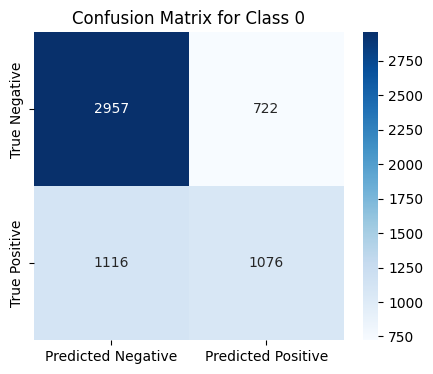

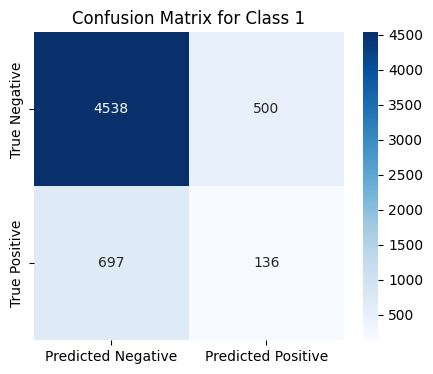

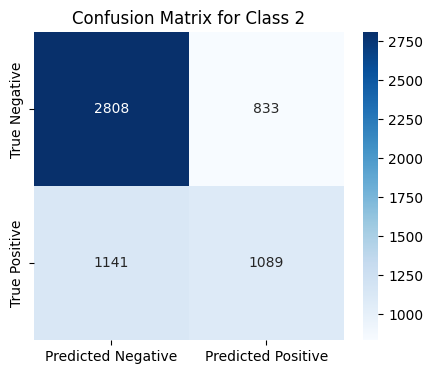

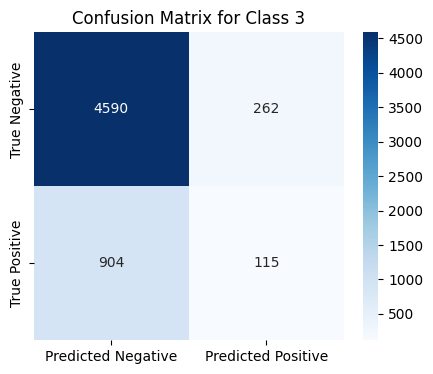

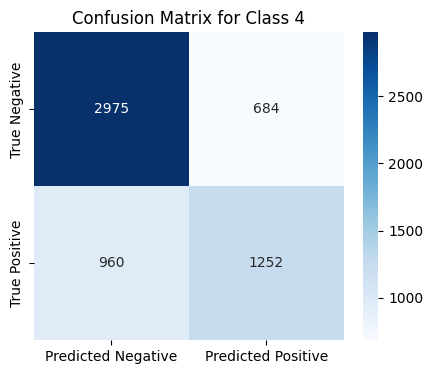

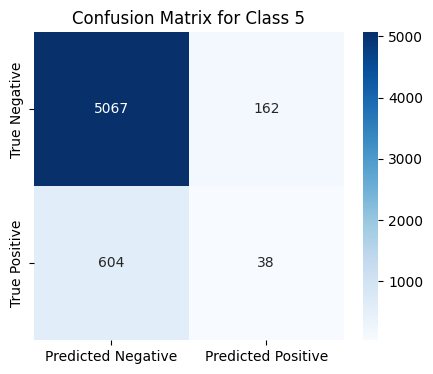

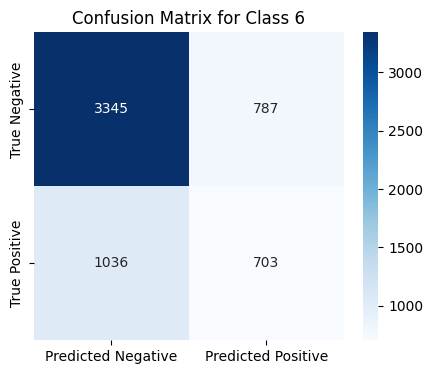

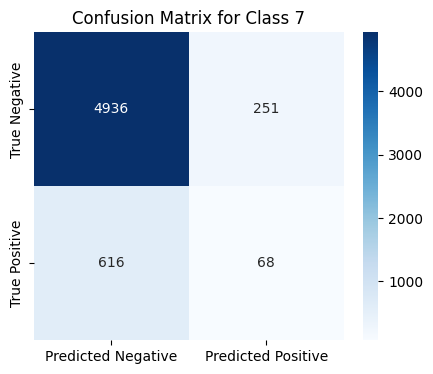

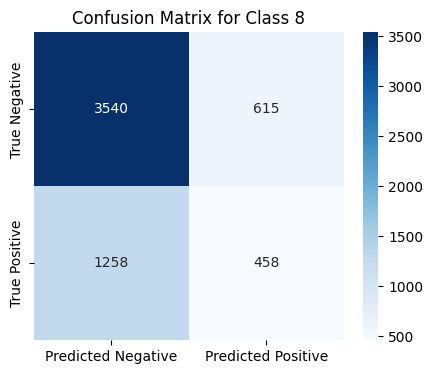

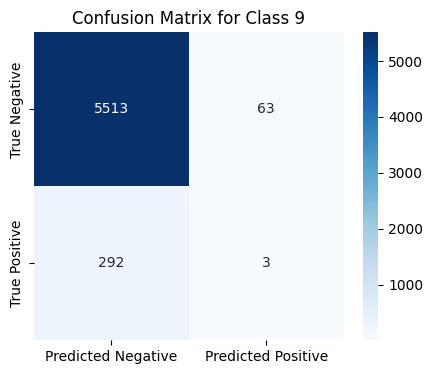

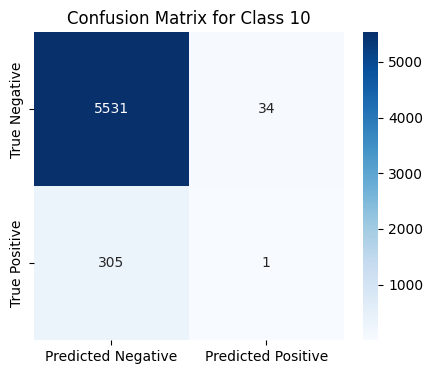

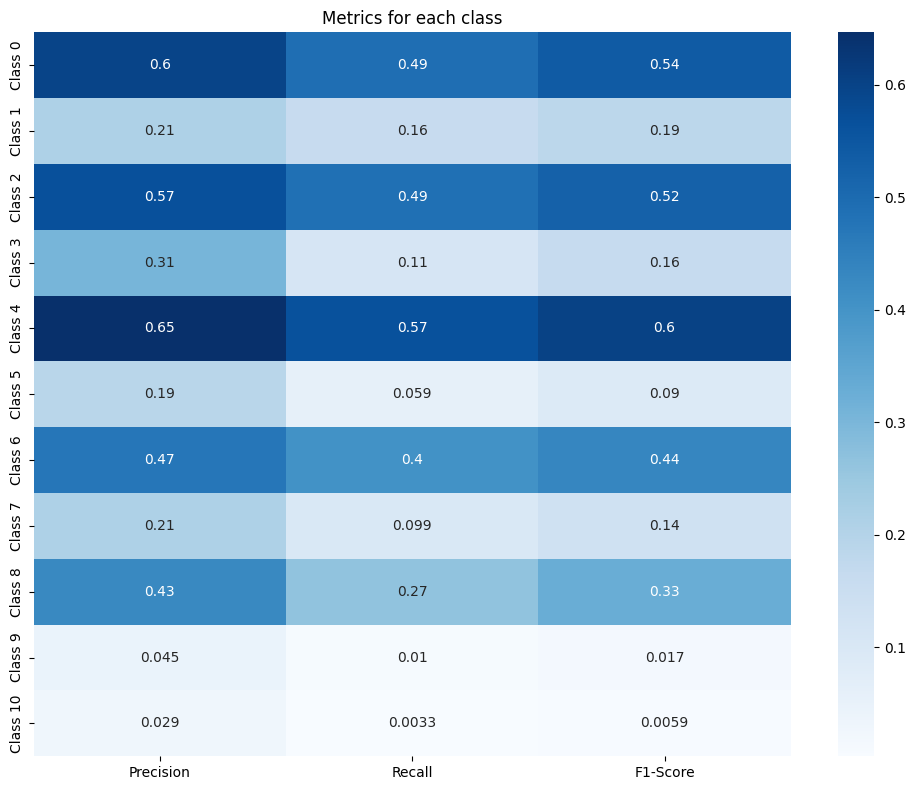

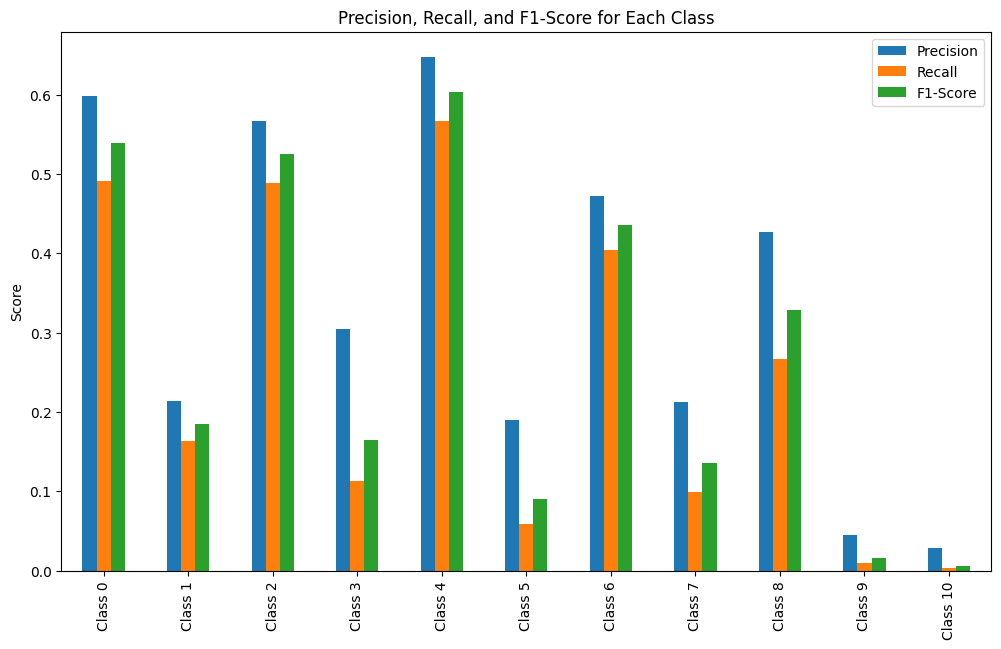

In [51]:
# Plot confusion matrix and other metrics
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Compute confusion matrix
mcm = multilabel_confusion_matrix(labels_valid, predictions_valid)

# 1. Individual Heatmaps
class_names = [f'Class {i}' for i in range(predictions_valid.shape[1])]
for idx, matrix in enumerate(mcm):
    plt.figure(figsize=(5, 4))
    sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['True Negative', 'True Positive'])
    plt.title(f'Confusion Matrix for {class_names[idx]}')
    plt.show()

# 2. Aggregate Metrics Heatmap
precision_per_class = precision_score(labels_valid, predictions_valid, average=None)
recall_per_class = recall_score(labels_valid, predictions_valid, average=None)
f1_per_class = f1_score(labels_valid, predictions_valid, average=None)

metrics_df = pd.DataFrame({
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1-Score': f1_per_class
}, index=class_names)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(metrics_df, annot=True, cmap='Blues')
plt.title('Metrics for each class')
plt.tight_layout()  # Adjust layout to not cut off edges

# Log the heatmap to wandb
wandb.log({"Metrics Heatmap": wandb.Image(ax.get_figure())})
plt.show()

# 3. Histogram of Metrics
metrics_df.plot(kind='bar', figsize=(12, 7))
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-Score for Each Class')
plt.show()

In [52]:
wandb.finish()

In [53]:
from huggingface_hub import notebook_login
notebook_login()

In [54]:
ia3_model.push_to_hub("glikithvinayaka/ia3_emotion_detection")

README.md:   0%|          | 0.00/5.17k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


adapter_model.safetensors:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/glikithvinayaka/ia3_emotion_detection/commit/c5193dea1edcdfb1228319016f34d9ba153365ca', commit_message='Upload model', commit_description='', oid='c5193dea1edcdfb1228319016f34d9ba153365ca', pr_url=None, pr_revision=None, pr_num=None)

# Test Set Predictions

In [55]:
import torch
from peft import PeftModel, PeftConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer

peft_model_id = "glikithvinayaka/ia3_emotion_detection"
config = PeftConfig.from_pretrained(peft_model_id)
config.base_model_name_or_path
base_model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path,
                                                                num_labels=11,
                                                                problem_type="multi_label_classification")
tokenizer = AutoTokenizer.from_pretrained(config.base_model_name_or_path)


adapter_config.json:   0%|          | 0.00/430 [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of GemmaForSequenceClassification were not initialized from the model checkpoint at google/gemma-1.1-2b-it and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
base_model

GemmaForSequenceClassification(
  (model): GemmaModel(
    (embed_tokens): Embedding(256000, 2048, padding_idx=0)
    (layers): ModuleList(
      (0-17): 18 x GemmaDecoderLayer(
        (self_attn): GemmaSdpaAttention(
          (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (k_proj): Linear(in_features=2048, out_features=256, bias=False)
          (v_proj): Linear(in_features=2048, out_features=256, bias=False)
          (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
          (rotary_emb): GemmaRotaryEmbedding()
        )
        (mlp): GemmaMLP(
          (gate_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (up_proj): Linear(in_features=2048, out_features=16384, bias=False)
          (down_proj): Linear(in_features=16384, out_features=2048, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): GemmaRMSNorm()
        (post_attention_layernorm): GemmaRMSNorm()
      )
    )
    

In [57]:
# Load the Lora model
inference_model = PeftModel.from_pretrained(base_model, peft_model_id)

adapter_model.safetensors:   0%|          | 0.00/2.94M [00:00<?, ?B/s]

In [58]:
inference_model

PeftModelForSequenceClassification(
  (base_model): IA3Model(
    (model): GemmaForSequenceClassification(
      (model): GemmaModel(
        (embed_tokens): Embedding(256000, 2048, padding_idx=0)
        (layers): ModuleList(
          (0-17): 18 x GemmaDecoderLayer(
            (self_attn): GemmaSdpaAttention(
              (q_proj): Linear(
                (base_layer): Linear(in_features=2048, out_features=2048, bias=False)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 2048x1])
              )
              (k_proj): Linear(
                (base_layer): Linear(in_features=2048, out_features=256, bias=False)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.FloatTensor of size 256x1])
              )
              (v_proj): Linear(
                (base_layer): Linear(in_features=2048, out_features=256, bias=False)
                (ia3_l): ParameterDict(  (default): Parameter containing: [torch.Fl

In [59]:
import pandas as pd
from datasets import Dataset


# Load test data
test_data = pd.read_csv("/content/drive/MyDrive/data/datasets/test.csv")

# Preprocess test data
X_test_cleaned = test_data['Tweet'].tolist()

# Replace 'NONE' with 0 in the label columns
label_columns = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']
test_data[label_columns] = test_data[label_columns].replace('NONE', 0).to_numpy(dtype=np.int64)


In [60]:
# Convert label columns to int type
test_data[label_columns] = test_data[label_columns].astype(int)

# Create Dataset object for test set
testset = Dataset.from_dict({
    'text': X_test_cleaned,
    'labels': test_data[label_columns].values.tolist()
})


In [61]:
def tokenize_fn(batch):
    return tokenizer(text = batch["text"], truncation=True)

In [62]:
tokenized_dataset= testset.map(tokenize_fn, batched=True)
tokenized_dataset = tokenized_dataset.remove_columns(
    ['text']
)
# tokenized_dataset.set_format(type='torch')

Map:   0%|          | 0/3259 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [63]:
import numpy as np
from sklearn.metrics import accuracy_score, f1_score

def calculate_metrics_TEST(eval_pred):
    # Unpack logits and labels
    logits, labels = eval_pred

    # Calculate probabilities using sigmoid function
    probabilities = 1 / (1 + np.exp(-logits))

    # Convert probabilities to binary predictions using a threshold of 0.25
    predictions = (probabilities >= 0.25).astype(int)

    # Print average probability
    print(np.average(probabilities))

    # Calculate accuracy and F1 score
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())
    f1 = f1_score(labels, predictions, average='macro', zero_division=0)

    # Return metrics
    return {'accuracy': accuracy, 'f1': f1, 'predictions': predictions}


In [64]:
tokenized_dataset

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 3259
})

In [65]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,
    do_train=False,
    do_eval=False,
    remove_unused_columns=False,
    report_to=[]
)

In [66]:
# Create the trainer instance
trainer = CustomTrainer(
    model=inference_model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    compute_metrics=calculate_metrics_TEST,
)

In [67]:
# Make predictions on the test dataset
predictions = trainer.predict(tokenized_dataset)


0.3411718


In [68]:
predictions

PredictionOutput(predictions=array([[ 1.5014406 , -2.3309436 ,  0.8405841 , ..., -2.354337  ,
        -0.82035   , -1.217649  ],
       [ 0.14029388, -1.1092471 , -1.6760154 , ..., -0.48476067,
        -1.1029289 , -2.090456  ],
       [ 0.11056632, -0.8979023 ,  0.7839047 , ..., -0.90123415,
        -0.15157156, -1.9174632 ],
       ...,
       [ 0.3813441 , -1.0473995 , -0.6723883 , ...,  0.7703428 ,
        -1.6681601 , -3.348911  ],
       [-0.40542778, -1.5227493 , -0.7679212 , ..., -2.6556273 ,
        -3.2890682 , -4.7005024 ],
       [-0.9906385 , -0.41012016,  0.02826695, ..., -0.08904986,
         0.35080287, -3.002366  ]], dtype=float32), label_ids=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), metrics={'test_loss': 0.5082406401634216, 'test_accuracy': 0.42991436302267844, 'test_f1': 0.0, 'test_predictions': array([[1,

In [69]:
len(predictions.predictions)

3259

In [70]:
# Post-process predictions
predicted_labels = np.argmax(predictions.predictions, axis=1)


In [71]:
predictions

PredictionOutput(predictions=array([[ 1.5014406 , -2.3309436 ,  0.8405841 , ..., -2.354337  ,
        -0.82035   , -1.217649  ],
       [ 0.14029388, -1.1092471 , -1.6760154 , ..., -0.48476067,
        -1.1029289 , -2.090456  ],
       [ 0.11056632, -0.8979023 ,  0.7839047 , ..., -0.90123415,
        -0.15157156, -1.9174632 ],
       ...,
       [ 0.3813441 , -1.0473995 , -0.6723883 , ...,  0.7703428 ,
        -1.6681601 , -3.348911  ],
       [-0.40542778, -1.5227493 , -0.7679212 , ..., -2.6556273 ,
        -3.2890682 , -4.7005024 ],
       [-0.9906385 , -0.41012016,  0.02826695, ..., -0.08904986,
         0.35080287, -3.002366  ]], dtype=float32), label_ids=array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), metrics={'test_loss': 0.5082406401634216, 'test_accuracy': 0.42991436302267844, 'test_f1': 0.0, 'test_predictions': array([[1,

In [72]:
import pandas as pd

# Extract the 'test_predictions' array from the predictions dictionary
test_predictions_array = predictions.metrics['test_predictions']

# Create a DataFrame from the 'test_predictions' array
test_predictions_df = pd.DataFrame(test_predictions_array)

# Print or further manipulate the DataFrame as needed
print(test_predictions_df)


      0   1   2   3   4   5   6   7   8   9   10
0      1   0   1   0   1   0   1   0   0   1   0
1      1   0   0   1   0   0   0   0   1   0   0
2      1   1   1   0   1   0   0   0   1   1   0
3      0   1   0   1   1   0   0   1   1   0   0
4      1   0   1   1   1   0   1   0   1   1   0
...   ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..
3254   1   1   1   1   0   0   0   0   1   0   0
3255   1   0   1   0   1   0   1   0   1   0   0
3256   1   1   1   0   1   0   1   0   1   0   0
3257   1   0   1   1   1   0   1   0   0   0   0
3258   1   1   1   0   1   1   1   0   1   1   0

[3259 rows x 11 columns]


In [73]:
import pandas as pd

# Load test.csv to get the first column
test_df = pd.read_csv("/content/drive/MyDrive/data/datasets/test.csv")

first_column = test_df.iloc[:, 0]

# Convert eval_predictions to a DataFrame
predictions_df = pd.DataFrame(test_predictions_df)

# Concatenate the first column with predictions_df
result_df = pd.concat([first_column, predictions_df], axis=1)
print(result_df)


              ID  0  1  2  3  4  5  6  7  8  9  10
0     2018-01559  1  0  1  0  1  0  1  0  0  1   0
1     2018-03739  1  0  0  1  0  0  0  0  1  0   0
2     2018-00385  1  1  1  0  1  0  0  0  1  1   0
3     2018-03001  0  1  0  1  1  0  0  1  1  0   0
4     2018-01988  1  0  1  1  1  0  1  0  1  1   0
...          ... .. .. .. .. .. .. .. .. .. ..  ..
3254  2018-03848  1  1  1  1  0  0  0  0  1  0   0
3255  2018-00416  1  0  1  0  1  0  1  0  1  0   0
3256  2018-03717  1  1  1  0  1  0  1  0  1  0   0
3257  2018-03504  1  0  1  1  1  0  1  0  0  0   0
3258  2018-00115  1  1  1  0  1  1  1  0  1  1   0

[3259 rows x 12 columns]


In [74]:
result_df.to_csv('/content/drive/MyDrive/data/datasets/ia3_gemma.csv', index=False)